# Loading Imagenette using SwiftData

In [1]:
%install-location $cwd/swift-install
%install '.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")' Path
%install '.package(url: "https://github.com/sgugger/SwiftCV.git", .branch("master"))' SwiftCV
%install '.package(url: "https://github.com/sgugger/SwiftData.git", .branch("master"))' SwiftData

Installing packages:
	.package(url: "https://github.com/mxcl/Path.swift", from: "0.16.1")
		Path
	.package(url: "https://github.com/sgugger/SwiftCV.git", .branch("master"))
		SwiftCV
	.package(url: "https://github.com/sgugger/SwiftData.git", .branch("master"))
		SwiftData
With SwiftPM flags: []
Working in: /tmp/tmpw9wixbrt/swift-install
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/swift: /home/sgugger/anaconda3/lib/libuuid.so.1: no version information available (required by /home/sgugger/swift/usr/bin/swift)
/home/sgugger/swift/usr/bin/s

In [2]:
import Path
import TensorFlow
import SwiftData
import SwiftCV
import Foundation

In [3]:
//For image show
import Python
let plt = Python.import("matplotlib.pyplot")

In [4]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


This notebook assumes you have [Imagenette](https://github.com/fastai/imagenette) downloaded in the path defined below. Here is the link to [compressed dataset](https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz).

In [5]:
let dataPath = Path.home/".fastai"/"data"

## Utils

Some simple function to open and preprocess images before batching.

In [6]:
func openImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

SwiftData provides a function to easily collect all the files in a directory, so let's gather all Imagenette filenames and look at the first one.

In [7]:
let path = dataPath/"imagenette2"/"train"
let fnames = collectFiles(under: path, recurse: true, filtering: ["jpeg", "jpg"])

In [8]:
func showCVImage(_ img: Mat) {
    let tensImg = Tensor<UInt8>(cvMat: img)!
    let numpyImg = tensImg.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

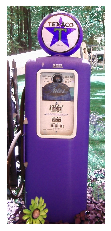

In [9]:
showCVImage(openImage(fnames[0]))

With openCV images, the channels are in BGR instead of RGB so we need to siwtch them:

In [10]:
func BGRToRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

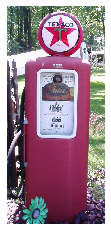

In [11]:
showCVImage(BGRToRGB(openImage(fnames[0])))

We will need to resize our images to be able to batch them

In [12]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

And finally we'll need to convert them to a S4TF Tensor:

In [13]:
func cvImgToTensor(_ img: Mat) -> Tensor<UInt8> {
    
    return Tensor<UInt8>(cvMat: img)!
}

The whole transformation process is defined below, using the composition operator `>|` defined in SwiftData.

In [14]:
let processImage = openImage >| BGRToRGB >| { resize($0, size: 224) } >| cvImgToTensor

To show a Tensor representing an image, we'll use the following function:

In [15]:
func showTensorImage<S> (_ img: Tensor<S>) where S: NumpyScalarCompatible {
    let numpyImg = img.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

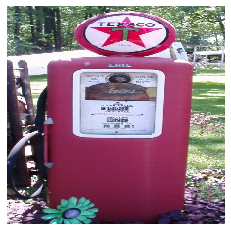

In [16]:
showTensorImage(processImage(fnames[0]))

## Creating a `Batcher`

SwiftData introduces a structure named `Batcher` that will lazily load your data (with some flags to potentially shuffle or drop the last incomplete batch) and put it in batches. An instance of `Batcher` conforms to the `Sequence` protocol (so you can iterate through it) and also provides a `count` property.

### Labels

Before we begin, we need to know how to label our data. Here the labels are given by the names of the parent folder. We gather all possibilities before creating a map from label to index.

In [17]:
let allLabels = fnames.map { $0.parent.basename() }
let labels = Array(Set(allLabels)).sorted()
let labelToInt = Dictionary(uniqueKeysWithValues: labels.enumerated().map{ ($0.element, $0.offset) })
print(labelToInt)

["n02979186": 2, "n03000684": 3, "n03028079": 4, "n03888257": 9, "n02102040": 1, "n03394916": 5, "n03425413": 7, "n01440764": 0, "n03445777": 8, "n03417042": 6]


Note that the labels are in the word2vec format. The correspondence, if needed is the following:
- n01440764='tench',
- n02102040='English springer',
- n02979186='cassette player',
- n03000684='chain saw',
- n03028079='church',
- n03394916='French horn',
- n03417042='garbage truck',
- n03425413='gas pump',
- n03445777='golf ball',
- n03888257='parachute'

### Config

The `Batcher` is a very low-level API that gives you total flexibility to go from the initial items (here our filenames) to a batch. To do this you must first create a structure confirming to the `BatcherConfig` protocol that implements a few hooks. Here the full `BatcherConfig` protocol
``` swift
public protocol BatcherConfig {
    associatedtype Item
    associatedtype Sample
    associatedtype RawBatch
    associatedtype Batch
    
    func processItem(_ item: Item) -> Sample
    func processSamples(_ samples: [Sample]) -> [Sample]
    func collateSamples(_ samples: [Sample]) -> RawBatch 
    func processBatch(_ batch: RawBatch) -> Batch
}
``` 

The `Item` type correspond the base elements of your dataset. You then (optionnaly) process your `Item` to get a `Sample`. For instance, if your item is a `Path`, processing it to a Sample means opening the corresponding file and taking the label, to return a tuple with a `Tensor` and an `Int`. If your dataset is already ready to be batched, you'll likely have `Item == Sample` and `processItem` will default to noop.

`processSamples` is another hook once we have gathered the list of samples we want to batch, allowing you to modify your list of samples before the collation. This is particularly useful when your samples don't all have the same size (for example if you wanted to resize to the smallest/biggest size in your list of samples, or for padding in text).

`collateSamples` explain how to concatenate a collection of samples into a batch, then finally `processBatch` is some post-processing step on the formed batch (which also defaults to noop if `RawBatch == Batch`).

You can see below an example of config suitable for ImageClassification. You just need to pass along how to open and label your images.

In [18]:
struct ImageClassificationConfig<Scalar>: BatcherConfig where Scalar: Numeric&TensorFlowScalar{
    typealias Item = Path
    typealias Sample = (Tensor<Scalar>, Int)
    typealias RawBatch = (Tensor<Scalar>, Tensor<Int32>)
    typealias Batch = (Tensor<Float>, Tensor<Int32>)
    
    let openImage: (Path) -> Tensor<Scalar>
    let labelFunc: (Path) -> Int
    
    init(openImage: @escaping (Path) -> Tensor<Scalar>, labelFunc: @escaping (Path) -> Int) {
        (self.openImage, self.labelFunc) = (openImage, labelFunc)
    }
    
    func processItem(_ item: Item) -> Sample {
        return (openImage(item), labelFunc(item))
    }
    
    func collateSamples(_ samples: [Sample]) -> RawBatch {
        return (Tensor(stacking: samples.map { $0.0 }), Tensor(samples.map { Int32($0.1) }))
    }
    
    func processBatch(_ batch: RawBatch) -> Batch {
        return (Tensor<Float>(batch.0) / 255.0, batch.1)
    }
}

In [19]:
let config = ImageClassificationConfig(openImage: processImage,
                                       labelFunc: { labelToInt[$0.parent.basename()]! })

And we have our batcher!

In [20]:
let batcher = Batcher(config, dataset: fnames, batchSize: 256, numWorkers: 8)

We can look at the first batch:

In [21]:
let b = batcher.first(where: {_ in true})!

In [22]:
b.0.shape

▿ [256, 224, 224, 3]
  ▿ dimensions : 4 elements
    - 0 : 256
    - 1 : 224
    - 2 : 224
    - 3 : 3


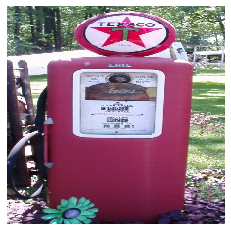

In [23]:
showTensorImage(b.0[0])

And time how long it takes to iterate though the whole training data:

In [24]:
import Dispatch

In [25]:
SetNumThreads(0)

In [26]:
let start = DispatchTime.now()
for b in batcher {
    var s = (b.0.shape, b.1.shape)
}
let end = DispatchTime.now()
let nanoseconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
let seconds = nanoseconds / 1e9
print(seconds)

10.3964829
